#### **Imports**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, SVR
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from pickle import dump, load

#### Model Selection & Functions

In [2]:
lr = LogisticRegression()
gb = GradientBoostingClassifier(n_estimators=20, random_state = 42)
xg = XGBClassifier()
bernoulli = BernoulliNB()
svm = SVC()

models = [lr, gb, xg, bernoulli, svm]

In [61]:
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

In [37]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Loading and exploring the data

In [3]:
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['spam', 'sms'])

In [4]:
df.head()

,spam,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spam    5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


#### Data Cleaning

In [6]:
#Checking for null values
df.isnull().sum()

spam    0
sms     0
dtype: int64

In [7]:
#Checking for duplicated
df.duplicated().sum()

403

In [8]:
df = df.drop_duplicates()

In [9]:
df = df.reset_index(inplace=False, drop=True)
df.shape

(5169, 2)

In [10]:
df.to_csv('sms_clean.csv', index=False)

#### EDA

In [11]:
df.spam.value_counts()

spam
ham     4516
spam     653
Name: count, dtype: int64

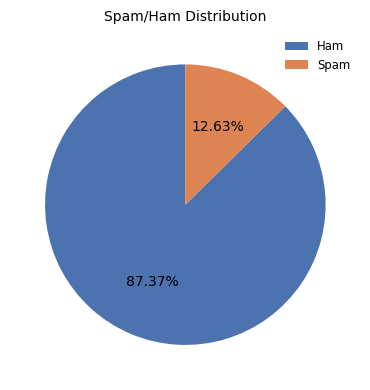

In [12]:
legend=['Ham', 'Spam']
colours = sns.color_palette('deep')
fig = plt.figure(figsize=(6,4))
df.spam.value_counts().plot(kind='pie', autopct='%1.2f%%', startangle=90, colors=colours, labels=None)
plt.ylabel('')
plt.title('Spam/Ham Distribution', fontsize='medium')
plt.legend(legend, frameon=False, fontsize='small', loc='best')
plt.tight_layout()
plt.show()

#### Preparing the data

In [13]:
df["spam"] = df["spam"].apply(lambda x: 1 if x == "spam" else 0).astype(int)
df.head()

,spam,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [73]:
#Processing test
'''df['sms'] = df['sms'].apply(preprocess_text)
df['sms'] = df['sms'].apply(lemmatize_text)'''

In [14]:
df['sms'] = df['sms'].str.strip().str.lower().replace('\t', ' ').replace('\n', ' ').replace('.', '')

In [15]:
df.head()

,spam,sms
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


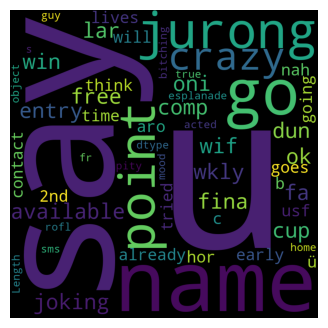

In [16]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(df["sms"]))

fig = plt.figure(figsize = (4,4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Data split

In [17]:
X = df.drop('spam', axis=1)
y = df['spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print('Train data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)

Train data: (4135, 1) (4135,)
Test data: (1034, 1) (1034,)


#### Transforming data into array

In [19]:
vector = TfidfVectorizer()

#tokens_list_train = [" ".join(tokens) for tokens in X_train['sms']]
#tokens_list_test = [" ".join(tokens) for tokens in X_test['sms']]

X_train = vector.fit_transform(X_train['sms']).toarray()
X_test = vector.transform(X_test['sms']).toarray()

In [20]:
#Saving the vector
dump(vector, open("vector_tfidf.sav", "wb"))

### **Training the models**

In [21]:
#models_dict = []

for model in models:
    print(f'Fitting {model.__class__.__name__}...')
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    print(f'F1 Score on train data is {f1_train:.2f}')
    print(f'F1 Score on test data is {f1_test:.2f}\n')

    #models_dict.append({'model': model.__class__.__name__, 'acc_train': acc_train, 'acc_test': acc_test})

Fitting LogisticRegression...
F1 Score on train data is 0.87
F1 Score on test data is 0.86

Fitting GradientBoostingClassifier...
F1 Score on train data is 0.79
F1 Score on test data is 0.73

Fitting XGBClassifier...
F1 Score on train data is 0.99
F1 Score on test data is 0.87

Fitting BernoulliNB...
F1 Score on train data is 0.94
F1 Score on test data is 0.91

Fitting SVC...
F1 Score on train data is 0.99
F1 Score on test data is 0.93



#### Optimizing the best model

##### RandomizedSearch

In [95]:
hyperparams = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'degree': [1,2,3,4,5]
}
op = RandomizedSearchCV(estimator=svm, param_distributions=hyperparams, n_iter=8, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
op

RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=8, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'shrinking': [True, False]},
                   random_state=42, scoring='accuracy')

In [23]:
hyperparams = {
    'force_alpha': [True, False],
    'alpha': [0, 1.0, 2.0],
    'fit_prior': [True, False],
    #'binarize': [None, 2.0, 5.0]
    }

op = RandomizedSearchCV(estimator=bernoulli, param_distributions=hyperparams, n_iter=8, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
op

RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_iter=8, n_jobs=-1,
                   param_distributions={'alpha': [0, 1.0, 2.0],
                                        'fit_prior': [True, False],
                                        'force_alpha': [True, False]},
                   random_state=42, scoring='accuracy')

In [24]:
op.fit(X_train, y_train)
print("Best Hyperparameters:", op.best_params_)
op_best = op.best_estimator_

Best Hyperparameters: {'force_alpha': False, 'fit_prior': True, 'alpha': 0}


C:\Users\ferna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


In [26]:
op_best.fit(X_train, y_train)
y_pred_train = op_best.predict(X_train)
y_pred_test = op_best.predict(X_test)

C:\Users\ferna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


In [27]:
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)
print(f'F1 on train data: {f1_train:.2f}')
print(f'F1 on test data:  {f1_test:.2f}')

F1 on train data: 0.99
F1 on test data:  0.93


##### GridSearch

In [182]:
grid_op = GridSearchCV(estimator=xg, param_grid=hyperparams, scoring='accuracy', n_jobs=-1, cv=5)
grid_op

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='accuracy')

In [183]:
grid_op.fit(X_train, y_train)
print("Best Hyperparameters:", grid_op.best_params_)
grid_op = op.best_estimator_

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


In [184]:
grid_op.fit(X_train, y_train)
y_pred_train = grid_op.predict(X_train)
y_pred_test = grid_op.predict(X_test)

In [185]:
acc_train_grid = accuracy_score(y_train, y_train_pred)
acc_test_grid = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on train data: {acc_train_grid:.2f}')
print(f'Accuracy on test data:  {acc_test_grid:.2f}')

Accuracy on train data: 0.89
Accuracy on test data:  0.73


#### Saving the model

In [28]:
dump(bernoulli, open("bernoulli_spam.sav", "wb"))

In [30]:
model = load(open("bernoulli_spam.sav", "rb"))

In [31]:
y = list(model.predict(X_test))

In [32]:
y[6]

0

In [33]:
from collections import Counter
# Use Counter to count unique values
counts = Counter(y)

for value, count in counts.items():
    if value == 1:
        print(f'Spam: {count}')
    else:
        print(f'Not spam: {count}')

Not spam: 916
Spam: 118


In [37]:
'''def predict_spam(str):
    sentence = lemmatize_text(preprocess_text(str))
    tokens = [" ".join(tokens) for tokens in sentence]
    tokens_vector = vector.transform(tokens).toarray()
    prediction = np.argmax(model.predict(tokens_vector))
    if prediction == 0:
        return 'Not spam'
    else:
        return 'Spam'
        '''

def predict_spam(str):
    sentence = [str.strip().lower().replace('\t', ' ').replace('\n', ' ').replace('.', '')]
    sentence_vector = vector.transform(sentence).toarray()
    prediction = model.predict(sentence_vector)
    if prediction == 1:
        return 'Spam'
    else:
        return 'Not spam'

In [43]:
sentence = "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

In [44]:
predict_spam(sentence)

'Not spam'